# [Project 1] GAN을 사용한 데이터 증강

____________________

### 프로젝트 목표
- GAN 모델을 사용하여 세상에 존재하지 않는 새로운 학습 이미지 생성


________________

### 프로젝트 목차
1. __데이터 읽기__: MNIST 데이터셋 이해<br>


2. __데이터 전 처리__: 딥러닝 모델에 필요한 입력값 형식으로 처리<br>
    2.1. Normalize 진행<br>
    2.2. 데이터 train, valid 나누기<br>
    2.3. 데이터 클래스 0,1로 나누기<br>


3. __딥러닝 모델 학습__: Generator, Discriminator 모델을 사용하여 학습 수행<br>
    3.1. Generator 모델 생성 <br>
    3.2. Discriminator 모델 생성<br>
    3.3. 모델 학습


4. __데이터 생성__: 학습된 모델을 바탕으로 새로운 데이터 생성<br>
    4.1. 생성된 데이터 시각화<br>



---

## 프로젝트 개요

저작권이 중요한 시대에, 딥러닝 모델은 수백만 개의 파라미터를 조정하는데 필요한 대규모 데이터는 구하기가 어려운 경우가 많습니다. 때문에, 학습 데이터를 얻기 위해 GAN 모델은 이미지 생성, 데이터 감소, 데이터 확장 등 다양한 분야에서 활용되고 있으며, 강력한 생성 능력을 가진 모델 중 하나로 사용되고 있습니다.


이번 프로젝트에서는 MNIST 숫자 데이터를 가지고, Generator, Discriminator 2개의 모델을 생성하고, 새로운 이미지 생성이 잘 되는지 확인해봅시다.

____

In [1]:
# torch, torch.nn, torch.optim, torchvision.transforms, torchvision.datasets, torch.utils.data, matplotlib 등의 패키지 import
# 재현성을 위해 torch.manual_seed()을 사용하여 random_seed=42로 고정하십시오.

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

random_seed = 42
torch.manual_seed(random_seed)

# Load MNIST Dataset

In [2]:
# transorms을 Normalize((0.5,), (0.5,)과 ToTensor()를 사용하여 구성하십시오.
# MNIST 데이터를 root는 'data/', train은 True, 위에서 생성한 transform을 사용하여 다운로드 하십시오.

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) 
])

dataset = MNIST(root='data/', train=True, transform=transform, download=True)


100.0%


Extracting data/MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\raw



100.0%


Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\raw



9.9%

100.0%


Extracting data/MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST\raw



100.0%

Extracting data/MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST\raw



In [3]:
# GAN 생성 모델은 cpu로 돌리면 시간이 오래 걸리기 때문에 0, 1 클래스만 사용하겠습니다.

filtered_indices = (dataset.targets == 0) | (dataset.targets == 1)
dataset.data = dataset.data[filtered_indices]
dataset.targets = dataset.targets[filtered_indices]


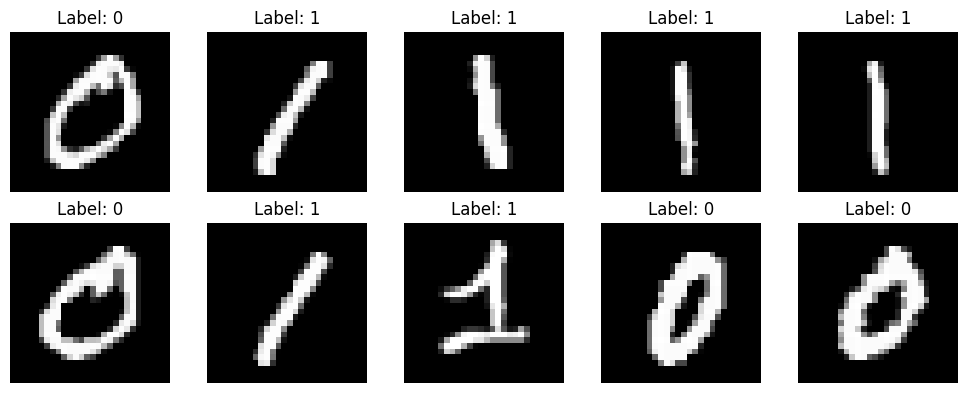

In [4]:
# 0, 1로 구성된 데이터가 맞는지 시각화 

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flatten()):
    img = dataset.data[i].numpy()
    label = dataset.targets[i].item()
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# MNIST DataLader 생성

In [5]:
# shuffler과 numworkers=4, batch_size=64를 사용하여 DataLoader를 생성하십시오.
# Load MNIST Dataset

batch_size = 64
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Create Generator Network

In [6]:
# Generator 클래스 정의
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.model = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 256, kernel_size=(3, 3), stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=2),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(-1, self.z_dim, 1, 1)
        return self.model(x)

# Create Discriminator Network

In [7]:
# Discriminator 클래스 정의
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), stride=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5), stride=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5), stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),

            nn.Flatten(),
            nn.Linear(in_features=64, out_features=1)
        )

    def forward(self, x):
        return self.model(x)

In [8]:
# generator 모델에 z_dim=100을 사용하고 cpu를 사용할 수 있게 생성하십시오.
# discriminator 모델을 cpu를 사용할 수 있게 생성하십시오.

z_dim = 100
device = 'cpu'
generator = Generator(z_dim).to(device)
discriminator = Discriminator().to(device)

In [9]:
# generator 모델을 찾기위해 nn.ConvTranspose2d, nn.Conv2d를 isinstance() 사용하여 생성하십시오.
# nn.init.normal_()을 사용하여 가중치를 평균이 0.0 이고 표준편차가 0.02인 정규분포를 따르도록 랜덤하게 초기화 하십시오.
# nn.init.constant_()를 사용하여 편향을 0으로 초기화하십시오.

def weights_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
# 정의한 가중치 초기화 학습을 generator 모델에 적용하십시오.

generator.apply(weights_init)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
    (10): Tanh()
  )
)

# 손실함수를 선언하고, 각 모델에 옵티아미저 적용

In [11]:
# Loss function 으로 BCEWithLogitsLoss를 사용하십시오.
# 각각의 모델 파라미터에 optim.Adam을 사용하여 lr = 0.0002, betas = (0.5, 0.999)를 적용하십시오.

lr = 0.0002
criterion = nn.BCEWithLogitsLoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

# 학습 진행

10번 epoch 입니다.


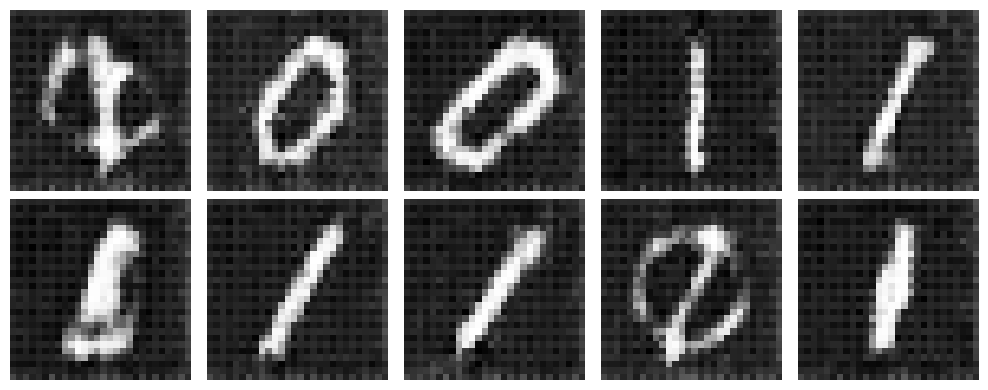

Discriminator Loss: 0.979250431060791, Generator Loss: 1.0534062385559082
20번 epoch 입니다.


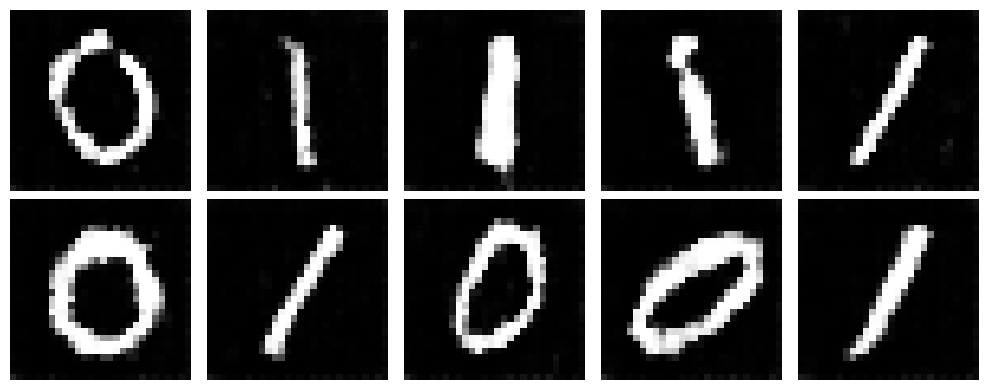

Discriminator Loss: 1.0668636560440063, Generator Loss: 1.2628099918365479


In [ ]:
# real_labels = torch.ones()를 사용하여 생성하십시오.
# fake_labels = torch.zeros()를 사용하여 생성하십시오.

# === Train the Discriminator === #
# images를 discriminator모델에 적용하고, criterion()을 사용하여 real_labels 손실값을 계산하십시오.
# torch.randn()을 사용하여 fake images를 생성하십시오.
# generator 모델에 적용하고, 나온 이미지에 detach()를 적용하고  criterion()을 사용하여 fake_labels 손실값을 계산하십시오.
# 출력된 손실값을 더하고 backward()연산을 적용하십시오
# Discriminator optimizer에 zero_grad(), step()을 적용하십시오. 

# === Train the Generator === #
# torch.randn()을 사용하여 fake images를 생성하십시오.
# generator 모델에 적용하고, 나온 이미지에 discriminator()를 적용하고  criterion()을 사용하여 real_labels 손실값을 계산하십시오.
# 출력된 손실값에 backward()연산을 적용하십시오
# generator optimizer에 zero_grad(), step()을 적용하십시오. 


# Lists to store loss values for visualization
num_epochs = 20

d_losses = []
g_losses = []

# Training loop
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        batch_size = images.size(0)
        images = images.to(device)

        # Create labels for real and fake images
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # === Train the Discriminator === #
        # Real images
        real_outputs = discriminator(images)
        d_loss_real = criterion(real_outputs, real_labels)

        # Fake images
        z = torch.randn(batch_size, z_dim).to(device)
        fake_images = generator(z)
        fake_outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(fake_outputs, fake_labels)

        # Discriminator loss
        d_loss = d_loss_real + d_loss_fake

        # Backpropagation and optimization
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # === Train the Generator === #
        z = torch.randn(batch_size, z_dim).to(device)
        fake_images = generator(z)
        outputs = discriminator(fake_images)

        # Generator loss
        g_loss = criterion(outputs, real_labels)

        # Backpropagation and optimization
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    # Save loss values for visualization
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

    # Show generated images for every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'{epoch + 1}번 epoch 입니다.')
        with torch.no_grad():
            z = torch.randn(10, z_dim).to(device)  # Show 10 images in a 2x5 grid
            generated_images = generator(z).detach().cpu()
            fig, axes = plt.subplots(2, 5, figsize=(10, 4), sharex=True, sharey=True)
            for i, ax in enumerate(axes.flatten()):
                img = generated_images[i].squeeze().numpy()
                ax.imshow(img, cmap='gray')
                ax.axis('off')
            plt.tight_layout()
            plt.show()
        
        print(f'Discriminator Loss: {d_losses[-1]}, Generator Loss: {g_losses[-1]}')
